/tmp/ipython-input-2332701121.py:44: DeprecationWarning: The class ``qiskit.primitives.sampler.Sampler`` is deprecated as of qiskit 1.2. It will be removed no earlier than 3 months after the release date. All implementations of the `BaseSamplerV1` interface have been deprecated in favor of their V2 counterparts. The V2 alternative for the `Sampler` class is `StatevectorSampler`.
  vqc = VQC(feature_map=feature_map, ansatz=ansatz, optimizer=optimizer, sampler=Sampler())


Entrenando VQC...
Precisión VQC: 0.52
Entrenando Random Forest...
Precisión Random Forest: 0.90

Generando gráficos...


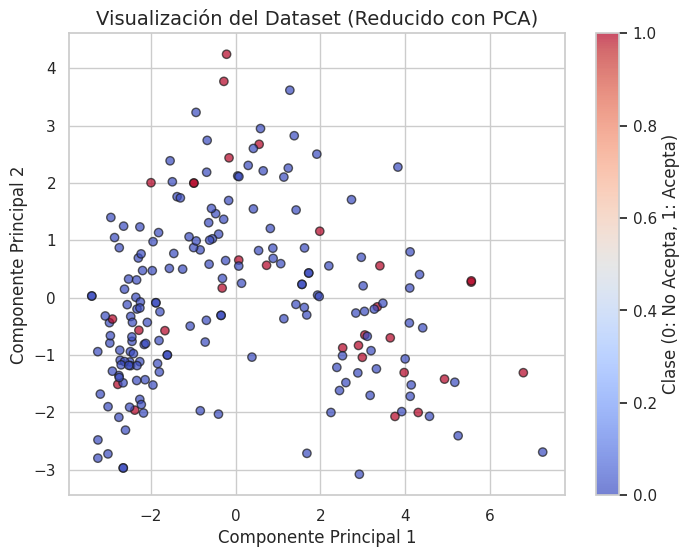

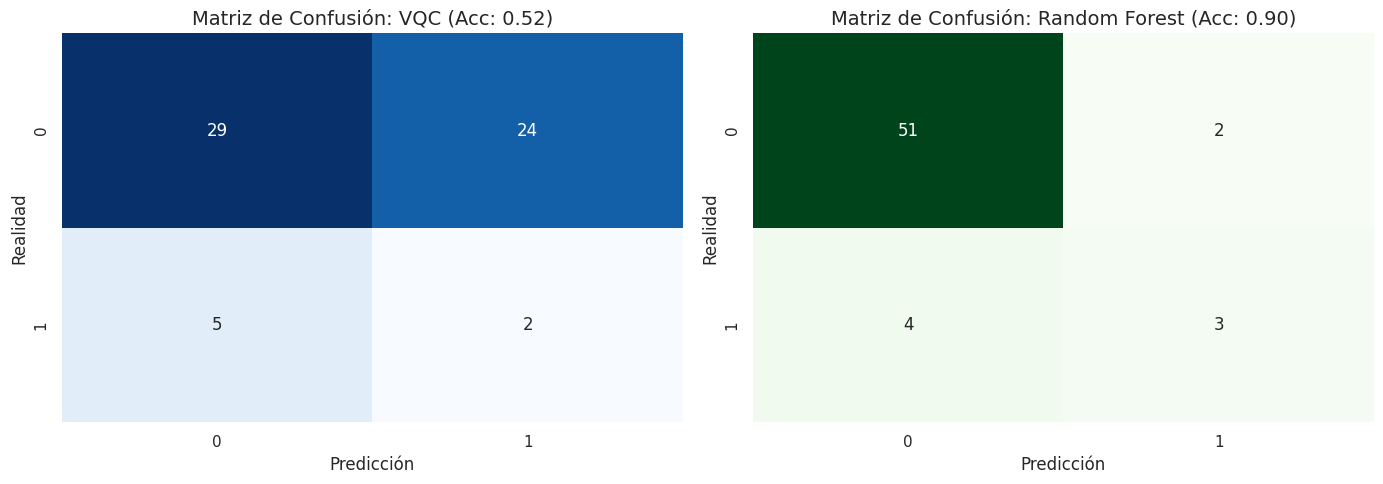

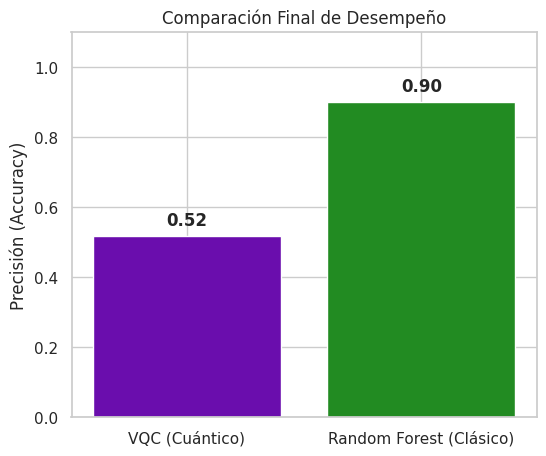

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.metrics import classification_report, confusion_matrix

# Qiskit Imports
from qiskit.circuit.library import ZZFeatureMap, RealAmplitudes
from qiskit_algorithms.optimizers import COBYLA
from qiskit_machine_learning.algorithms import VQC
from qiskit.primitives import Sampler

# --- 1. PREPROCESAMIENTO ---
# Cargar datos
df = pd.read_csv('/content/sample_data/dataset_proyecto.csv')
df = df.drop(columns=['ID', 'Dt_Customer']).dropna()

# Definir variables
target = 'Response'
X = pd.get_dummies(df.drop(columns=[target]), drop_first=True)
y = df[target].values

# Escalar y PCA (4 Qubits)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
pca = PCA(n_components=4)
X_pca = pca.fit_transform(X_scaled)

# Muestreo "Ligero" para Simulación (200 datos)
X_small, y_small = resample(X_pca, y, n_samples=200, random_state=42, stratify=y)
X_train, X_test, y_train, y_test = train_test_split(X_small, y_small, test_size=0.3, random_state=42)

# --- 2. ENTRENAMIENTO MODELO CUÁNTICO (VQC) ---
num_features = X_train.shape[1]
feature_map = ZZFeatureMap(feature_dimension=num_features, reps=1)
ansatz = RealAmplitudes(num_qubits=num_features, reps=1)
optimizer = COBYLA(maxiter=60)

vqc = VQC(feature_map=feature_map, ansatz=ansatz, optimizer=optimizer, sampler=Sampler())

print("Entrenando VQC...")
vqc.fit(X_train, y_train)
score_vqc = vqc.score(X_test, y_test)
print(f"Precisión VQC: {score_vqc:.2f}")

# --- 3. ENTRENAMIENTO MODELO CLÁSICO (Random Forest) ---
print("Entrenando Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)
score_rf = rf.score(X_test, y_test)
print(f"Precisión Random Forest: {score_rf:.2f}")

# ==========================================
# --- 4. GENERACIÓN DE DIAGRAMAS VISUALES ---
# ==========================================
print("\nGenerando gráficos...")

# Configuración de estilo
sns.set(style="whitegrid")

# GRÁFICO 1: Distribución de Datos (PCA 2D)
# Muestra qué tan mezclados están los datos que intentan clasificar
plt.figure(figsize=(8, 6))
plt.scatter(X_small[:, 0], X_small[:, 1], c=y_small, cmap='coolwarm', edgecolors='k', alpha=0.7)
plt.title('Visualización del Dataset (Reducido con PCA)', fontsize=14)
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.colorbar(label='Clase (0: No Acepta, 1: Acepta)')
plt.show()

# GRÁFICO 2: Matrices de Confusión Comparativas
# Compara dónde se equivocó cada modelo
y_pred_vqc = vqc.predict(X_test)
y_pred_rf = rf.predict(X_test)

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Matriz VQC
cm_vqc = confusion_matrix(y_test, y_pred_vqc)
sns.heatmap(cm_vqc, annot=True, fmt='d', cmap='Blues', ax=axes[0], cbar=False)
axes[0].set_title(f'Matriz de Confusión: VQC (Acc: {score_vqc:.2f})', fontsize=14)
axes[0].set_xlabel('Predicción')
axes[0].set_ylabel('Realidad')

# Matriz Random Forest
cm_rf = confusion_matrix(y_test, y_pred_rf)
sns.heatmap(cm_rf, annot=True, fmt='d', cmap='Greens', ax=axes[1], cbar=False)
axes[1].set_title(f'Matriz de Confusión: Random Forest (Acc: {score_rf:.2f})', fontsize=14)
axes[1].set_xlabel('Predicción')
axes[1].set_ylabel('Realidad')

plt.tight_layout()
plt.show()

# GRÁFICO 3: Comparación de Precisión (Bar Chart)
plt.figure(figsize=(6, 5))
models = ['VQC (Cuántico)', 'Random Forest (Clásico)']
accuracies = [score_vqc, score_rf]
colors = ['#6a0dad', '#228b22'] # Morado Cuántico vs Verde Bosque

bars = plt.bar(models, accuracies, color=colors)
plt.ylim(0, 1.1)
plt.ylabel('Precisión (Accuracy)')
plt.title('Comparación Final de Desempeño')

# Poner el número encima de la barra
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, f'{yval:.2f}', ha='center', va='bottom', fontsize=12, fontweight='bold')

plt.show()

In [1]:
!pip install qiskit qiskit-machine-learning
!pip install qiskit-algorithms
!pip install -U qiskit qiskit-machine-learning qiskit-algorithms

  Using cached qiskit-2.2.3-cp39-abi3-manylinux2014_x86_64.manylinux_2_17_x86_64.whl.metadata (12 kB)
